In [ ]:
!pip install tensorflow numpy matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive


In [ ]:
from google.colab import drive # This line imports the necessary module

drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/House_Data'  # Update the path to your dataset

Mounted at /content/drive


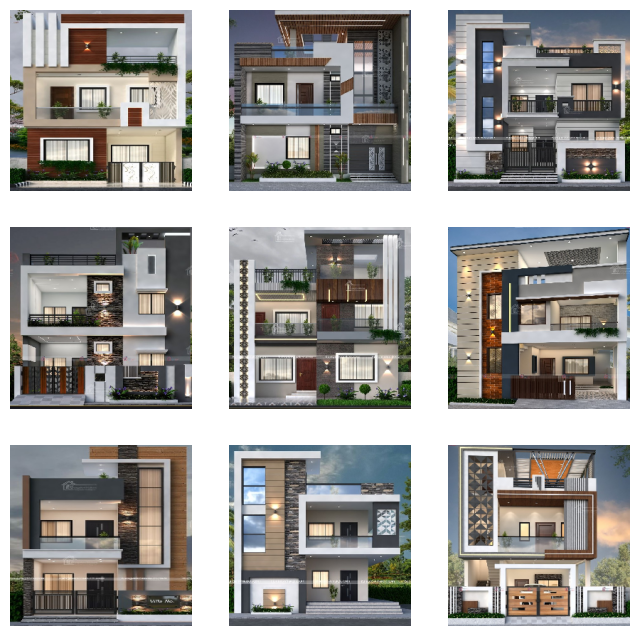

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Enable Mixed Precision Training for better memory usage on GPUs
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load and preprocess images with visualization
def load_image_dataset(dataset_path, image_size=(256, 256)):
    images = []
    for file_name in os.listdir(dataset_path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = tf.keras.preprocessing.image.load_img(os.path.join(dataset_path, file_name), target_size=image_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
            images.append(img)

    # Visualize some of the images loaded
    plt.figure(figsize=(8, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(((images[i] * 127.5) + 127.5).astype("uint8"))
        plt.axis('off')
    plt.show()

    return np.array(images)

dataset_path = '/content/drive/MyDrive/House_Data'  # Update the path to your dataset
images = load_image_dataset(dataset_path)

# Define Generator
def build_generator():
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(100,)))  # Use Input layer
    model.add(layers.Dense(16 * 16 * 512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 512)))  # Starting size (16, 16, 512)

    # Upsample to (32, 32, 256)
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to (64, 64, 128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to (128, 128, 64)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to (256, 256, 32)
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final output layer (256, 256, 3)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

# Define Discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(256, 256, 3)))  # Use Input layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator = build_generator()
discriminator = build_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4, epsilon=1e-7)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, epsilon=1e-7)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Print progress and losses after each epoch
        print(f"Epoch {epoch + 1} completed.")

        # Generate and save sample images for each epoch
        if (epoch + 1) % 5 == 0:  # Save every 5 epochs
            noise = tf.random.normal([16, 100])
            generated_images = generator(noise, training=False)
            plt.figure(figsize=(4, 4))
            for i in range(generated_images.shape[0]):
                plt.subplot(4, 4, i + 1)
                plt.imshow(((generated_images[i].numpy() * 127.5) + 127.5).astype("uint8"))
                plt.axis('off')
            plt.savefig(f'generated_image_epoch_{epoch + 1}.png')
            plt.show()

BUFFER_SIZE = 60000
BATCH_SIZE = 16  # Further reduced from 32 to 16 to fit more easily in memory

train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
EPOCHS = 20  # Start with fewer epochs for faster feedback

train(train_dataset, EPOCHS)

# Generate a sample image after training
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(((generated_image[0].numpy() * 127.5) + 127.5).astype("uint8"))
plt.axis('off')
plt.show()
